# Notebook de test des données lapi post-traitees

In [153]:
%load_ext autoreload
%autoreload 
import sys #c'est pas propre mais pour le moment pour importer mes modules perso dans le notebook je ne sais pas faire
sys.path.append(r'C:\Users\martin.schoreisz\git\Outils\Outils\Martin_Perso')
import Connexion_Transfert as ct
import donnees_posttraitees as t
import graphs as g
import pandas as pd
import geopandas as gpd
import numpy as np
import altair as alt
import datetime as dt
#pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_columns', 500)
#pd.set_option('display.max_rows', 50)
alt.data_transformers.enable('default', max_rows=None)
import os, math, re
from sklearn.cluster import DBSCAN
from sklearn import svm,datasets
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. import des données, traitement de mise en forme
## 1.1 Import
Les données sont importées sur la période du 24/01/19 au 23/02/19, sur laquelle il n'y a pas de manque de données à priori

In [3]:
%time df_passages, df_plaques, df_immat=t.ouvrir_fichier_lapi_final('2019-01-23 00:00:00','2019-02-13 23:59:59')

Wall time: 27min 49s


In [ ]:
#export au format svg des données TV
for i in range(1,20) :
    chemin=os.path.join(r'Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\Traitements\python\graphs\nb_veh_J_cam',f'cam{i}.svg')
    g.graph_nb_veh_jour_camera_multi_j(df_passages,'2019-01-23 00:00:00','2019-01-23 23:59:59',i,22).save(chemin)

## 1.3 Ajout de l'attribut de différenciation VL / PL

In [4]:
%time df_passages2=t.affecter_type(df_passages,df_immat)

Wall time: 4min 12s


In [5]:
%time df_passages3=t.affecter_type_nuit(df_passages2,df_immat)

Wall time: 42.3 s


### différenciation VL / PL

In [6]:
df_passages_pl=df_passages3.loc[df_passages3['l']==1].copy()

## 1.2. Suppression des doublons

### 1.2.1 Doublons

In [7]:
%time df_passages_ss_doublons=t.supprimer_doublons(df_passages_pl)

Wall time: 7.75 s


### 1.2.2 passages proches

In [ ]:
#pour visu
%time groupe_pl_rappro, groupe_pl=t.passages_proches(df_passages_ss_doublons)
jointure = g.analyse_passage_proches(groupe_pl_rappro, groupe_pl)
g.graph_passages_proches(jointure, groupe_pl_rappro)

In [8]:
#pour traitement
%time passg_recale_cam10=t.recalage_cam10(df_passages_ss_doublons)

Wall time: 1min 19s


## 1.4. Filtre des immatriculations non cohérentes

In [9]:
%time df_passages_immat_ok, df_immat_suppr=t.filtre_plaque_non_valable(passg_recale_cam10, df_plaques)

Wall time: 4min 40s


# 2. Identifier les trajets de transit

In [10]:
dico_od,  dico_passag, dico_tps_max=t.transit_temps_complet('2019-01-23 00:00:00',14,df_passages_immat_ok)

date : 2019-01-23 00:00:00 debut_traitement : 2019-06-13 16:25:35.977259
date : 2019-01-24 00:00:00 debut_traitement : 2019-06-13 16:26:36.198676
date : 2019-01-25 00:00:00 debut_traitement : 2019-06-13 16:27:34.169782
date : 2019-01-26 00:00:00 debut_traitement : 2019-06-13 16:28:35.029742
date : 2019-01-27 00:00:00 debut_traitement : 2019-06-13 16:29:29.174690
date : 2019-01-28 00:00:00 debut_traitement : 2019-06-13 16:30:10.141085
date : 2019-01-29 00:00:00 debut_traitement : 2019-06-13 16:31:23.499364
date : 2019-01-30 00:00:00 debut_traitement : 2019-06-13 16:32:48.714204
date : 2019-01-31 00:00:00 debut_traitement : 2019-06-13 16:34:13.257292
date : 2019-02-01 00:00:00 debut_traitement : 2019-06-13 16:35:46.001625
date : 2019-02-02 00:00:00 debut_traitement : 2019-06-13 16:37:30.586954
date : 2019-02-03 00:00:00 debut_traitement : 2019-06-13 16:39:09.716121
date : 2019-02-04 00:00:00 debut_traitement : 2019-06-13 16:40:31.744096
date : 2019-02-05 00:00:00 debut_traitement : 2019-

# 3. Filtrer les trajets selon un temps de parcours

## 3.1 Dataframe des temps de parcours de base

In [11]:
%time dixco_tpsmax_corrige=t.corriger_df_tps_parcours(dico_tps_max)

Wall time: 1.7 s


## 3.2 Identification du trafic de transit sans marge

In [12]:
#affectation des temps de parcours de reference
%time df_transit_tps_ref=t.jointure_temps_reel_theorique(dico_od,dixco_tpsmax_corrige,t.liste_complete_trajet)

Wall time: 1min 25s


In [13]:
#df des transit avec marge 0 ss extrapolation
%time df_transit_marge0_ss_extrapolation=t.identifier_transit(df_transit_tps_ref, 0)

Wall time: 12.4 s


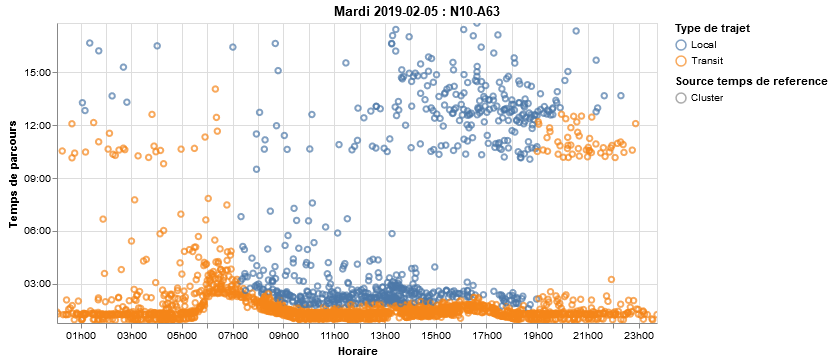

In [142]:
g.graph_transit_filtre(df_transit_marge0_ss_extrapolation,'2019-02-05 00:00:00', '2019-02-05 23:59:59','N10-A63')

## 3.3 Extrapolation pour recuperer les trajets manquants 

In [14]:
%%time
liste_od_ok=['A660-A62','A62-A63','A63-A62','A62-A10','A660-N10', 'A660-A10','N10-A63','A62-N10']
df_transit_extrapole=df_transit_marge0_ss_extrapolation.copy()
for od in [x for x in  df_transit_marge0_ss_extrapolation.o_d.unique().tolist() if x not in liste_od_ok ] : 
    for date in set([a[0].strftime('%Y-%m-%d') for a in t.creer_liste_date('2019-01-23',14)]):
            try : 
                 df_transit_extrapole=t.predire_type_trajet(df_transit_extrapole, od,date,600,35)
            except ValueError : 
                continue

Wall time: 2min 32s
Parser   : 113 ms


***exemple d'impact de l'extrapolation***

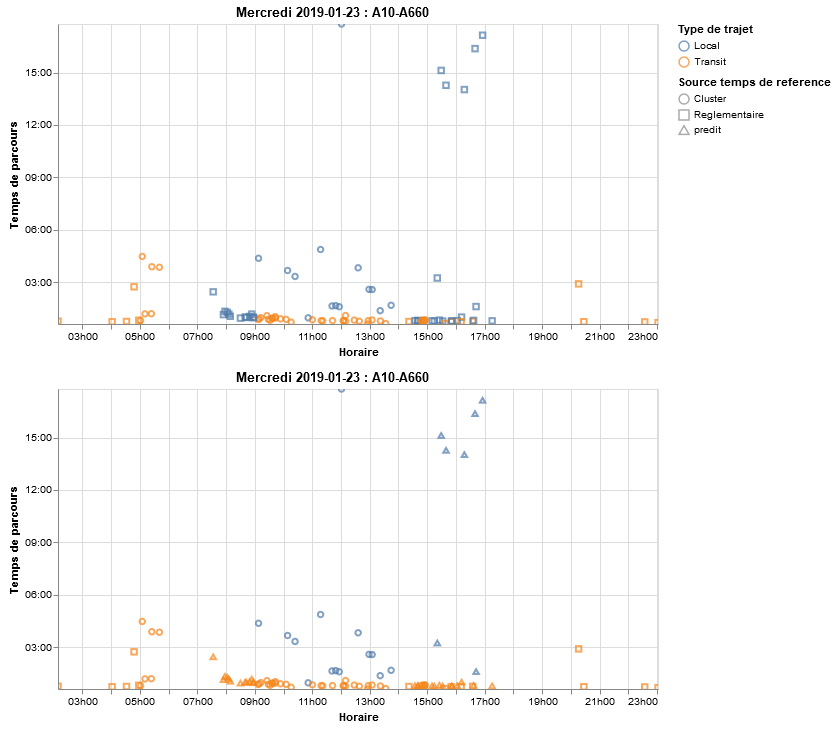

In [191]:
alt.vconcat(g.graph_transit_filtre_multiple(dico_df_transit['df_transit_marge0'],'2019-01-23 00:00:00', '2019-01-23 23:59:59','A10-A660', 1),
g.graph_transit_filtre_multiple(df_transit_extrapole,'2019-01-23 00:00:00', '2019-01-23 23:59:59','A10-A660', 1))            

***modification du dico des temps max avec ajout des temps de référence issu de l'extrapolation***

In [15]:
#localiser les periodes et o-d avec un temps de référence modifié
%time dixco_tpsmax_corrige=t.corriger_tps_parcours_extrapole(dixco_tpsmax_corrige,df_transit_extrapole)

## 3.4 appliquer une marge 

In [140]:
%%time
for i in [0,15,30,45,600] :
    dico_df_transit['df_transit_marge'+str(i)]=t.identifier_transit(df_transit_extrapole, i)

Wall time: 1min 30s


In [90]:
#exemple de visu sur 3 semaines
for od in dico_df_transit['df_transit_marge0'].o_d.unique(): 
    for i in [0,15,30,45,600] :
        nom_chemin=r'Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\Traitements\python\graphs\transit_J_OD\marge_'+str(i)+'_min'
        chemin=os.path.join(nom_chemin,f'{od}.svg')
        g.graph_transit_filtre_multiple(dico_df_transit['df_transit_marge'+str(i)],'2019-01-23 00:00:00', '2019-01-23 23:59:59',od, 22).save(chemin)

***Impact de la marge***

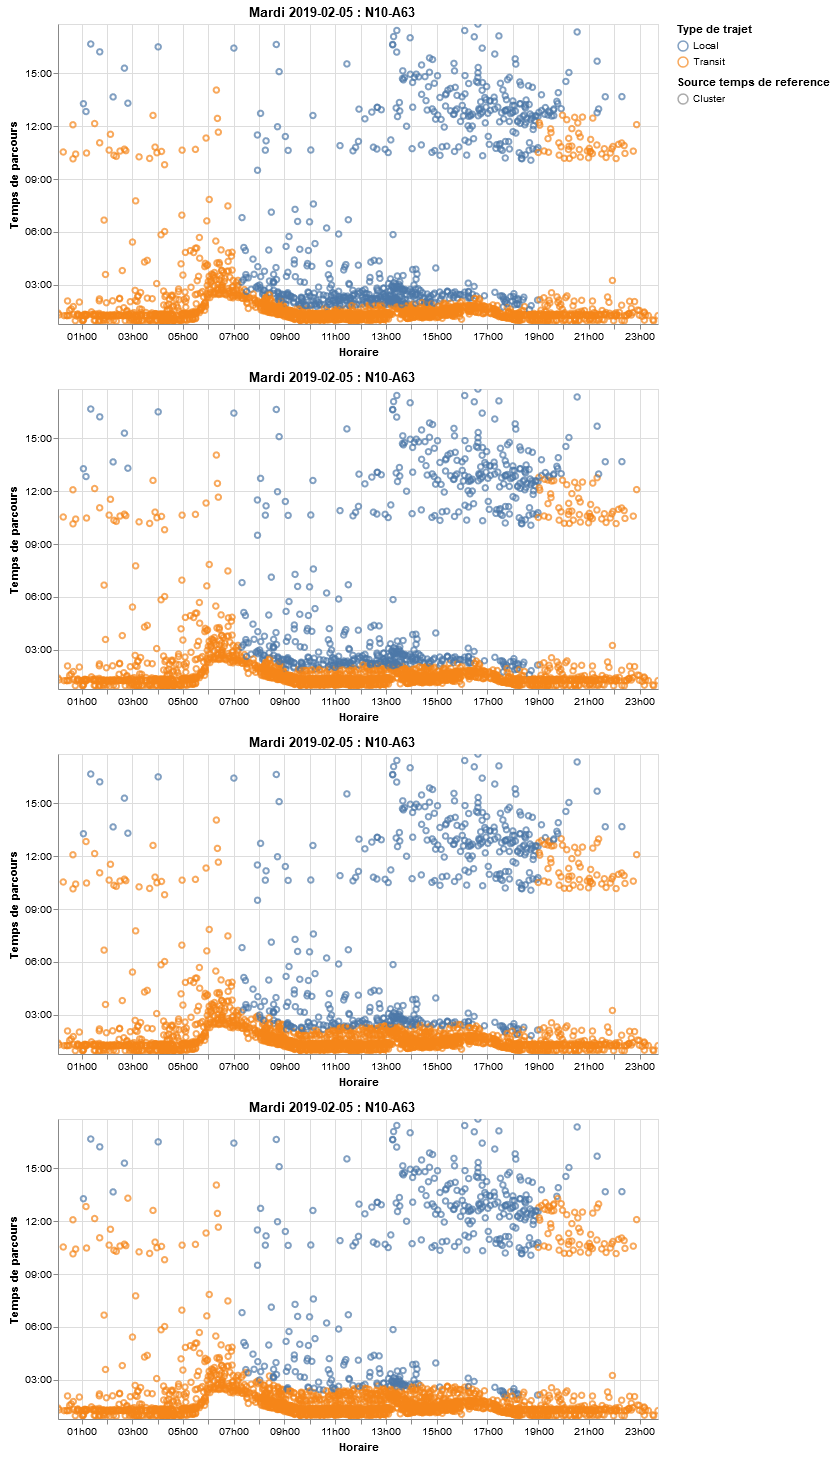

In [139]:
alt.vconcat(g.graph_transit_filtre(dico_df_transit['df_transit_marge0'],'2019-02-05 00:00:00', '2019-02-05 23:59:59','N10-A63'),
            g.graph_transit_filtre(dico_df_transit['df_transit_marge15'],'2019-02-05 00:00:00', '2019-02-05 23:59:59','N10-A63'),
            g.graph_transit_filtre(dico_df_transit['df_transit_marge30'],'2019-02-05 00:00:00', '2019-02-05 23:59:59','N10-A63'),
            g.graph_transit_filtre(dico_df_transit['df_transit_marge45'],'2019-02-05 00:00:00', '2019-02-05 23:59:59','N10-A63'))

***Filtre des données***

In [107]:
%%time
dico_df_od_ok={'df_od_ok_marge'+str(i):dico_df_transit['df_transit_marge'+str(i)].loc[dico_df_transit['df_transit_marge'+str(i)]['filtre_tps']==1]
         for i in [0,15,30,45,600]}
#dico_df_passag_ok={'df_passag_ok_marge'+str(i):t.trajet2passage(dico_df_od_ok['df_od_ok_marge'+str(i)],dico_passag) for i in [0,15,30,45,600]}

In [113]:
len(dico_df_od_ok['df_od_ok_marge600'])

181786

# 4. Correction des trajets depuis ou vers A660 relatifs à A63

In [163]:
#recuperer les passages correspondant aux trajets identifies
%time dico_passag_final=t.trajet2passage(df_transit_marge0_ss_extrapolation.loc[df_transit_marge0_ss_extrapolation['filtre_tps']==1],df_passages_immat_ok)

Wall time: 7min 33s
Parser   : 206 ms


In [165]:
%time df_od_corrige=t.correction_trajet(dico_passag_final, df_transit_marge0_ss_extrapolation.loc[df_transit_marge0_ss_extrapolation['filtre_tps']==1])

In [ ]:
df_od_corrige

# 5. Extrapolation des trajets non complets

In [176]:
#creer les donnees necessaires
%time df_filtre_A63,df_passage_transit,df_non_transit=t.param_trajet_incomplet('2019-01-23 00:00:00',df_od_corrige,df_passages_immat_ok,dico_passag_final)

Wall time: 49.6 s


In [177]:
#trajet de transit incomplet sans filtre sur temps de parcours
%time trajet_transit_incomplet2, passage2=t.transit_trajet_incomplet(df_filtre_A63,df_passage_transit,'2019-01-23 00:00:00',22, df_passages_immat_ok)

date : 2019-01-23 00:00:00 debut_traitement : 2019-06-12 14:54:04.020073
date : 2019-01-24 00:00:00 debut_traitement : 2019-06-12 15:01:01.873335
date : 2019-01-25 00:00:00 debut_traitement : 2019-06-12 15:05:23.262148
date : 2019-01-26 00:00:00 debut_traitement : 2019-06-12 15:08:32.904315
date : 2019-01-27 00:00:00 debut_traitement : 2019-06-12 15:11:05.174002
date : 2019-01-28 00:00:00 debut_traitement : 2019-06-12 15:12:08.854160
date : 2019-01-29 00:00:00 debut_traitement : 2019-06-12 15:14:56.228052
date : 2019-01-30 00:00:00 debut_traitement : 2019-06-12 15:17:36.516521
date : 2019-01-31 00:00:00 debut_traitement : 2019-06-12 15:19:26.509335
date : 2019-02-01 00:00:00 debut_traitement : 2019-06-12 15:22:00.341855
date : 2019-02-02 00:00:00 debut_traitement : 2019-06-12 15:24:06.190598
date : 2019-02-03 00:00:00 debut_traitement : 2019-06-12 15:25:43.932078
date : 2019-02-04 00:00:00 debut_traitement : 2019-06-12 15:26:28.703959
date : 2019-02-05 00:00:00 debut_traitement : 2019-

In [269]:
#affectation des temps de parcours de reference
%time df_transit_incomplet_tps_ref=t.jointure_temps_reel_theorique(trajet_transit_incomplet2,dixco_tpsmax_corrige,t.liste_trajet_incomplet,'incomplet')
#Maj de l'attruibut drapeau et Maj des autres attruibuts
df_transit_incomplet_tps_ref=t.identifier_transit(df_transit_incomplet_tps_ref, 0)
#mettre en forme les attributs
df_transit_incomplet_tps_ref=df_transit_incomplet_tps_ref[['date_cam_1', 'immat', 'state', 'l', 'date_cam_2', 'cameras', 'origine',
       'destination', 'o_d', 'tps_parcours', 'period', 'date', 'temps', 'type',
       'tps_parcours_theoriq','temps_filtre', 'filtre_tps']]
#filtrer le df : 
df_transit_incomplet_tps_ref_final=df_transit_incomplet_tps_ref.loc[df_transit_incomplet_tps_ref['filtre_tps']==1].copy()
#ajouter l'attribut d'identification des trajets 
df_transit_incomplet_tps_ref_final['correction_o_d']=True
df_transit_incomplet_tps_ref_final['correction_o_d_type']='extrapole'
#6. Ajouter au df des o_d précédents : 
df_od_final=pd.concat([df_od_corrige,df_transit_incomplet_tps_ref_final],sort=False)

Wall time: 16 s


# 6. Créer les tableaux de matrice o_d

## 6.1 Nb total de veh sur la periode

In [114]:
# dico des o-d nombre total
dico_mat_od={'mat_od_marge'+str(i):pd.pivot_table(dico_df_od_ok['df_od_ok_marge'+str(i)],values='l', index='origine', 
                                                  columns='destination',aggfunc='count', margins=True).fillna('NC') for i in [0,15,30,45,600]}

In [126]:
dico_mat_od['mat_od_marge0']

destination,A10,A62,A63,A660,A89,N10,All
origine,,,,,,,
A10,NC,4929,7195,1838,175,NC,14137
A62,4850,NC,286,683,686,6228,12733
A63,7084,197,NC,NC,1540,39583,48404
A660,1747,511,NC,NC,709,7508,10475
A89,193,599,2193,1058,NC,NC,4043
N10,NC,3894,32294,6723,NC,NC,42911
All,13874,10130,41968,10302,3110,53319,132703


## 6.2 par jour ouvre

In [69]:
# attention, cen'est qu'un exemple, car pour certaines o_d il faut que les jours sans données soit suppr de la df de base, et que le coeff divisuer soit adapté.
df_od_ouvre_final=dico_df_transit['df_transit_marge0'].loc[dico_df_transit['df_transit_marge0'].set_index('date_cam_1').index.dayofweek<5]
pivot_od_marge30_jo=pd.pivot_table(df_od_ouvre_final,values='l', index='origine', columns='destination',aggfunc='count', margins=True).fillna('NC')
pivot_od_marge30_jo_j=pivot_od_marge30_jo.applymap(lambda x : round(x/16) if (isinstance(x,float) or isinstance(x,int)) else 'NC')
pivot_od_marge30_jo_j

destination,A10,A62,A63,A660,A89,N10,All
origine,,,,,,,
A10,NC,5713,9116,2128,320,NC,17277
A62,5772,NC,457,907,1003,7108,15247
A63,8579,295,NC,NC,2090,44031,54995
A660,2082,764,NC,NC,1027,7805,11678
A89,281,904,2922,1348,NC,NC,5455
N10,NC,4570,36173,6562,NC,NC,47305
All,16714,12246,48668,10945,4440,58944,151957


In [93]:
#comparatif des df en JO : 
(round(((pivot_od_marge45_jo.applymap(lambda x : round(x/16) if (isinstance(x,float) or isinstance(x,int)) else np.nan)/
 pivot_od_marge15_jo.applymap(lambda x : round(x/16) if (isinstance(x,float) or isinstance(x,int)) else np.nan))-1)*100))

destination,A10,A62,A63,A660,A89,N10,All
origine,,,,,,,
A10,NaN,7.0,16.0,13.0,11.0,NaN,12.0
A62,11.0,NaN,32.0,14.0,16.0,5.0,9.0
A63,22.0,19.0,NaN,NaN,18.0,13.0,15.0
A660,18.0,12.0,NaN,NaN,19.0,7.0,10.0
A89,20.0,14.0,21.0,14.0,NaN,NaN,17.0
N10,NaN,7.0,11.0,7.0,NaN,NaN,10.0
All,17.0,8.0,13.0,10.0,17.0,11.0,12.0


## 6.3 Impact methode de prediction sur marge0

In [160]:
pd.pivot_table(dico_extrapole_prediction['marge15'].loc[dico_extrapole_prediction['marge15']['filtre_tps']==1],values='l', index='origine', 
                                                  columns='destination',aggfunc='count', margins=True).fillna('NC')

destination,A10,A62,A63,A660,A89,N10,All
origine,,,,,,,
A10,NC,5643,8459,2469,341,NC,16912
A62,5489,NC,362,1100,1015,6909,14875
A63,8002,266,NC,NC,2031,41587,51886
A660,2093,834,NC,NC,1129,8239,12295
A89,292,937,2924,1551,NC,NC,5704
N10,NC,4536,34111,7461,NC,NC,46108
All,15876,12216,45856,12581,4516,56735,147780


# 6.4 Impact redressement vaeurs A63 et A660

In [173]:
# donnees de base
pl_transit_base=df_transit_marge0_ss_extrapolation.loc[df_transit_marge0_ss_extrapolation['filtre_tps']==1].copy()

In [175]:
pd.pivot_table(pl_transit_base, values='l',index='origine', columns='destination',aggfunc='count', margins=True).fillna('NC')

destination,A10,A62,A63,A660,A89,N10,All
origine,,,,,,,
A10,NC,5265,7658,1954,182,NC,15059
A62,5183,NC,306,740,734,6664,13627
A63,7400,202,NC,NC,1654,39887,49143
A660,1869,577,NC,NC,784,7882,11112
A89,207,659,2340,1125,NC,NC,4331
N10,NC,4143,32739,7086,NC,NC,43968
All,14659,10846,43043,10905,3354,54433,137240


In [169]:
# donnees redressee
pd.pivot_table(df_od_corrige,values='l', index='origine', columns='destination',aggfunc='count', margins=True).fillna('NC')

destination,A10,A62,A63,A660,A89,N10,All
origine,,,,,,,
A10,NC,5265,7666,1946,182,NC,15059
A62,5183,NC,332,714,734,6664,13627
A63,7760,233,NC,NC,1767,40181,49941
A660,1509,546,NC,NC,671,7588,10314
A89,207,659,2402,1063,NC,NC,4331
N10,NC,4143,32839,6986,NC,NC,43968
All,14659,10846,43239,10709,3354,54433,137240


# 6.5 impact trajets non complet

In [272]:
pd.pivot_table(df_od_final,values='l', index='origine', columns='destination',aggfunc='count', margins=True).fillna('NC')

destination,A10,A62,A63,A660,A89,N10,All
origine,,,,,,,
A10,NC,5298,7666,1946,182,NC,15092
A62,5183,NC,332,714,741,6692,13662
A63,7760,235,NC,NC,1777,40482,50254
A660,1509,546,NC,NC,671,7588,10314
A89,207,665,2402,1063,NC,NC,4337
N10,NC,4158,32839,6986,NC,NC,43983
All,14659,10902,43239,10709,3371,54762,137642


# vérifications

In [299]:
# trouver les passages correspondants aux trajets
passages_transit=t.trajet2passage(df_od_final,df_passages_immat_ok)

In [327]:
#trouver les passages non compris dans passages transit
passages_non_transit=df_passages_immat_ok.loc[
    ~df_passages_immat_ok.reset_index().set_index(['created', 'camera_id','immat']).index.isin(
    passages_transit.set_index(['created', 'camera_id','immat']).index.tolist())]

In [328]:
passages_non_transit.reset_index().sort_values('created').groupby('plaque_ouverte').agg(
    {'camera_id':lambda x : tuple(x),
     'created':lambda x: tuple(x)})

In [ ]:
%time t.trajet_non_transit(df_od_final,df_passages_immat_ok)

In [330]:
df_passages_immat_ok.loc[df_passages_immat_ok['plaque_ouverte']=='ZV419CZ'].sort_index()

,index,camera_id,immat,fiability,l,state,id,plaque_ouverte,chiffree,plaque_valide
created,,,,,,,,,,
2019-01-23 14:57:44,549952,3,aa208dd1b76a8266c4fbcad5257ca301ee6a91fd,99,1.0,SK,765103,ZV419CZ,aa208dd1b76a8266c4fbcad5257ca301ee6a91fd,True
2019-01-23 15:17:37,5796050,18,aa208dd1b76a8266c4fbcad5257ca301ee6a91fd,99,1.0,IT/SK,765104,ZV419CZ,aa208dd1b76a8266c4fbcad5257ca301ee6a91fd,True
2019-01-24 03:46:12,5805478,13,aa208dd1b76a8266c4fbcad5257ca301ee6a91fd,99,1.0,SK,765105,ZV419CZ,aa208dd1b76a8266c4fbcad5257ca301ee6a91fd,True


In [331]:
dico_od.loc[dico_od['plaque_ouverte']=='0011HMY']

,date_cam_1,index,immat,l,state,id,plaque_ouverte,chiffree,plaque_valide,date_cam_2,cameras,origine,destination,o_d,tps_parcours
28,2019-02-06 14:06:24,5923197,3e61a53a456a8490dd5eaba8e254dfce64e85356,1.0,ES,274525,0011HMY,3e61a53a456a8490dd5eaba8e254dfce64e85356,True,2019-02-06 15:48:20,"(15, 19, 4, 5)",A63,N10,A63-N10,01:41:56


In [332]:
df_transit_marge0_ss_extrapolation.loc[df_transit_marge0_ss_extrapolation['plaque_ouverte']=='0011HMY']

,date_cam_1,index,immat,l,state,id,plaque_ouverte,chiffree,plaque_valide,date_cam_2,cameras,origine,destination,o_d,tps_parcours,period,date,temps,type,tps_parcours_theoriq,temps_filtre,filtre_tps
26622,2019-02-06 14:06:24,5923197,3e61a53a456a8490dd5eaba8e254dfce64e85356,1.0,ES,274525,0011HMY,3e61a53a456a8490dd5eaba8e254dfce64e85356,True,2019-02-06 15:48:20,"(15, 19, 4, 5)",A63,N10,A63-N10,01:41:56,2019-02-06 14:00,2019-02-06 14:00:00,01:12:31,Cluster,01:03:47.194000,01:12:31,0


In [319]:
df_od_final.loc[df_od_final['plaque_ouverte']=='0004HPR']

,date_cam_1,index,immat,l,state,id,plaque_ouverte,chiffree,plaque_valide,date_cam_2,cameras,origine,destination,o_d,tps_parcours,period,date,temps,type,tps_parcours_theoriq,temps_filtre,filtre_tps,correction_o_d,correction_o_d_type
43685,2019-02-11 06:42:31,5892851.0,90c47ca725cd1681798ee0cc5135d3424b34bc16,1.0,ES,651033.0,0004HPR,90c47ca725cd1681798ee0cc5135d3424b34bc16,True,2019-02-11 09:18:07,"(15, 19, 4, 5, 11)",A63,A10,A63-A10,02:35:36,2019-02-11 06:30,2019-02-11 06:30:00,01:58:34.500000,moyenne Cluster,01:30:14.634000,12:58:34.500000,1,False,autre
126237,2019-02-13 12:36:04,5978969.0,90c47ca725cd1681798ee0cc5135d3424b34bc16,1.0,ES,651038.0,0004HPR,90c47ca725cd1681798ee0cc5135d3424b34bc16,True,2019-02-13 13:38:42,"(6, 3, 18, 13)",N10,A63,N10-A63,01:02:38,2019-02-13 12:00,2019-02-13 12:00:00,01:42:30,Cluster,01:04:01.001000,01:42:30,1,False,autre


In [320]:
passages_transit.loc[passages_transit['immat']=='90c47ca725cd1681798ee0cc5135d3424b34bc16']

,created,camera_id,immat,fiability,l,state
1273293,2019-02-11 06:42:31,15,90c47ca725cd1681798ee0cc5135d3424b34bc16,99,1.0,ES
1273294,2019-02-11 07:16:34,19,90c47ca725cd1681798ee0cc5135d3424b34bc16,99,1.0,ES
1273295,2019-02-11 07:40:54,4,90c47ca725cd1681798ee0cc5135d3424b34bc16,99,1.0,ES
1273296,2019-02-11 08:02:54,5,90c47ca725cd1681798ee0cc5135d3424b34bc16,99,1.0,ES
1273297,2019-02-11 09:18:07,11,90c47ca725cd1681798ee0cc5135d3424b34bc16,99,1.0,ES
1273307,2019-02-13 12:36:04,6,90c47ca725cd1681798ee0cc5135d3424b34bc16,88,1.0,ES
1273308,2019-02-13 12:47:26,3,90c47ca725cd1681798ee0cc5135d3424b34bc16,99,1.0,ES
1273309,2019-02-13 13:07:36,18,90c47ca725cd1681798ee0cc5135d3424b34bc16,99,1.0,ES
1273310,2019-02-13 13:38:42,13,90c47ca725cd1681798ee0cc5135d3424b34bc16,67,1.0,ES


In [325]:
df_passages_immat_ok.reset_index().set_index(['created', 'camera_id','immat']).head(10).index.tolist()

[(Timestamp('2019-01-22 23:35:35'),
  10,
  'a77790c06ce4ec9645a1a19c3b4cac8f3dfdb337'),
 (Timestamp('2019-01-22 23:35:39'),
  10,
  '473dc86d69ed520d3540f0bf93ad6c70de12f3fd'),
 (Timestamp('2019-01-22 23:36:47'),
  10,
  '2db21358da859f1ba734c65d7d44b6acc36b9e6a'),
 (Timestamp('2019-01-22 23:37:11'),
  10,
  'aa7b27afef061c864956bdb9cf12cc4ae9b66797'),
 (Timestamp('2019-01-22 23:43:14'),
  10,
  'f1bdbe5774359e55a7da86fd2ace27c61fc12a09'),
 (Timestamp('2019-01-22 23:44:15'),
  10,
  '1f3bf38d03797e56c7ec962e19f730c5696f7c30'),
 (Timestamp('2019-01-22 23:46:38'),
  10,
  'c3caf38ae7e035d14ac797d22465d766dae3384d'),
 (Timestamp('2019-01-22 23:47:09'),
  10,
  '328d5ea674af57d7251d491199fa8d65bcfb86b6'),
 (Timestamp('2019-01-22 23:52:52'),
  10,
  '070c89352dfbe361f5c851a55edf33b88af6cc3a'),
 (Timestamp('2019-01-22 23:53:01'),
  10,
  '973b50e5a2e8bfbc79cd976dc228911339506259')]

# 6.6 MJO

Pour faire du MJO il faut connaitre les dates à enlever de certaines O-D car il ya des trous dans les données, cf Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\donnees_verif_fiabilite\Synthese_absence_donnees.ods

depuis N10 : supprimer les 29/01 et 30/01<br>vers A10 supprimer le 01/02<br>vers A62 supprimer le 24/01

In [ ]:
df_od_final.loc[df_od_final['date_cam_1'].day!=pd.to_datetime('2019-29-01').day]

# 7. Différeciation Rocade Est-Ouest
>Cette analyse ne concerne que les trajets N10-A63, A10-A63, N10-A660, A10-A660

In [57]:
pivot_type_rocade

type_rocade,Autre,Est,Ouest,All
o_d,,,,
A10-A63,474,4126,153,4753
A10-A660,159,597,38,794
A63-A10,715,3053,38,3806
A660-A10,248,669,10,927
A660-N10,1184,2892,40,4116
N10-A63,2106,19016,644,21766
N10-A660,589,2205,101,2895
All,5475,32558,1024,39057


# 7. Analyse du nb de VL, PL, PL en transit par heure et par camera 
> Le pb c'est que pour les camera de la Rocade, parfois on les PL n'y sont pas vus, de même pour les chemins extrapoles ou pour ceux corrigés : le passage soit n'existe pas, soit la camera du passage ne correspond pas à la destination finalement utilisées

## 7.1 base : travail sur les données telles que créees

In [48]:
df_vl=df_passages2.loc[df_passages2['l']!=1]
df_pl=df_passages2.loc[df_passages2['l']==1]
#df_passages_transit=t.trajet2passage(dico_od_final,df_pl) deféini plus haut :dico_passag_final

In [49]:
%time synt_nb_veh_cam=t.pourcentage_pl_camera(df_pl,dico_passag_final, df_vl)

pl_tot =1920 , vl_tot=1920 , pl_transit=1262,pl_tot-joint-transit=1262
Wall time: 1.51 s


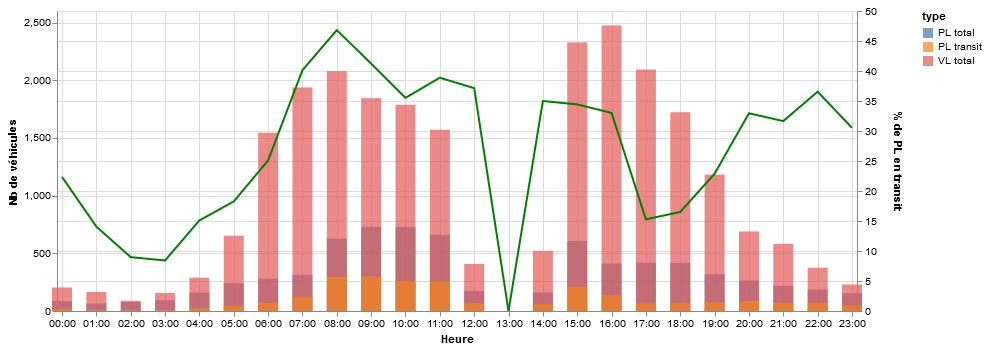

In [52]:
g.graph_VL_PL_transit_j_cam(synt_nb_veh_cam, '2019-01-29', 4)

## 7.2 Redressement au niveau de la Rocade

In [126]:
#determiner les passages fictifs
df_passage_transit_redresse, df_pl_redresse, trajets_rocade_non_vu=t.passages_fictif_rocade (t.liste_trajet_rocade, dico_od_final,dico_passag_final,df_pl)
#regrouper
%time synt_nb_veh_cam_redresse=t.pourcentage_pl_camera(df_pl_redresse,df_passage_transit_redresse, df_vl)

pl_tot =1920 , vl_tot=1920 , pl_transit=1262,pl_tot-joint-transit=1262
Wall time: 1.3 s


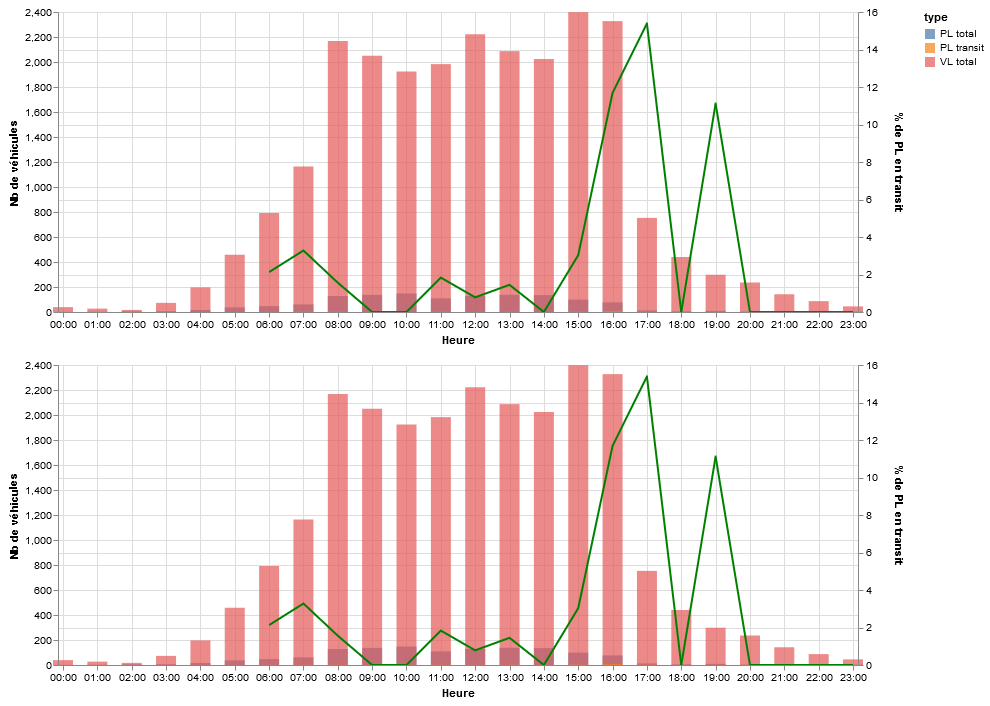

In [46]:
alt.vconcat(g.graph_VL_PL_transit_j_cam(synt_nb_veh_cam, '2019-01-28', 1),g.graph_VL_PL_transit_j_cam(synt_nb_veh_cam_redresse, '2019-01-28', 1))

## 7.3 Redressement des trajets extrapoles

>**A TESTER SUR JEU DE DONNEES COMPLET**

In [ ]:
# de même que opur la rocade, il faut ajouter des passages fictifs à la df des passages afin de pouvoir approximer mieux les parts de PL
#trouver les passages extrapoles
df_od_final.loc[df_od_final['correction_o_d_type']=='extrapole']
# tester la camera de debut :si c'est pas une des cameras d'entree - sortie du dispositif, on sait si le trajet est extrapole en début ou fin
#selon l'o_d crééer un passage fictuf avec le numero de la camera qui manque du trajets sensé avoir eu leiu
#estimer le temps de passage selon le temps theorique : date_cam_1 ou 2 +ou- temps ou temps theorique

## 7.4. Grouper les réusltats par JO

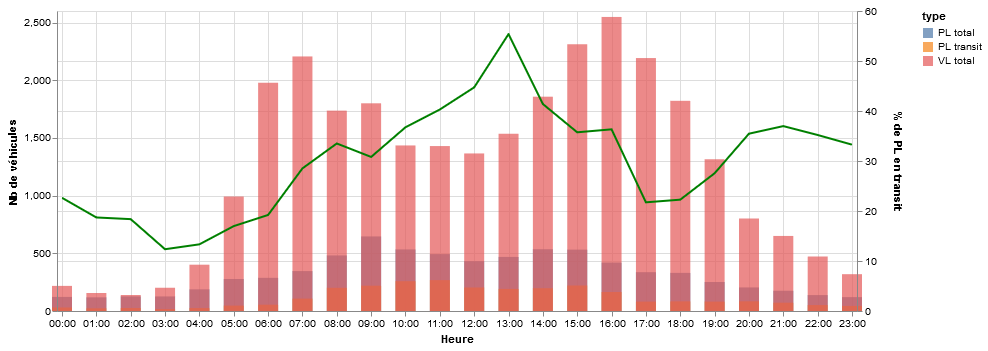

In [133]:
g.graph_VL_PL_transit_j_cam(synt_nb_veh_cam_redresse, 'JO', 4)

# 8. Temps de parcours

In [26]:
# on cherche à obtenir le temps de parcours moyen pour une camera, sur un jour ou les jours ouvres, par o_d
# on construit donc une df avec : immat, cam, tps_parcours, heure_Rocade
# pour l'heure à la Rocade : on va cehrcher dans les df_passage le passage:qui a la mm immat, dont la cam est 1,2,3,4 et dont le created est compris entre date_cam1et date_cam2

#isoler les passages concernes par la Rocade
passage_rocade=dico_passag_final.loc[(dico_passag_final['camera_id'].isin([1,2,3,4]))]# & (dico_passag_final['correction_o_d']==False)]

In [36]:
#jointure entre les o_d et les passages
o_d_joint_rocade=dico_od_final.merge(passage_rocade, on='immat', how='left')

In [109]:
#limiter les o_d là ou date du passages est ciompris entre les date 1 et date 2 de l'o_d
dico_od_Rocade_final=o_d_joint_rocade.loc[(o_d_joint_rocade['date_cam_1']<o_d_joint_rocade['created']) & 
                                          (o_d_joint_rocade['created']<o_d_joint_rocade['date_cam_2']) & 
                                          (o_d_joint_rocade['tps_parcours']<pd.Timedelta('4H'))]

In [155]:
#limiter les 
limite_donnees=dico_od_Rocade_final[['date_cam_1','immat','o_d','tps_parcours','created']].rename(columns={'created':'h_rocade'})

In [181]:
#filtrer selon une date ou des jours ouvrés ou mardi/jeudi : 
"""filtre_donnees=limite_donnees.loc[(limite_donnees.apply(lambda x : x['h_rocade'].dayofyear==pd.to_datetime('2019-01-28').dayofyear,axis=1)) & 
                          (pour_graph['o_d']=='A10-A62')].copy()"""
filtre_donnees=limite_donnees.loc[(limite_donnees.set_index('h_rocade').index.dayofweek<5) & 
                          (limite_donnees['o_d']=='A10-A63')].copy()
"""filtre_donnees=limite_donnees.loc[(limite_donnees.set_index('h_rocade').index.dayofweek.isin([1,3])) & 
                          (limite_donnees['o_d']=='A10-A62')].copy()"""

"filtre_donnees=limite_donnees.loc[(limite_donnees.set_index('h_rocade').index.dayofweek.isin([1,3])) & \n                          (limite_donnees['o_d']=='A10-A62')].copy()"

In [182]:
#transformer les valeur de temps en integer pour agregation
filtre_donnees['tps_parcours2']=filtre_donnees['tps_parcours'].values.astype(np.int64)

In [183]:
#mise en forme pour graph
groupe_h=filtre_donnees.set_index('h_rocade').resample('15T')['tps_parcours2'].mean()
#groupe_h['tps_parcours']=pd.to_timedelta(groupe_h['tps_parcours'])
groupe_h=pd.to_timedelta(groupe_h)
pour_graph=groupe_h.reset_index()
pour_graph['tps_parcours2']=pd.to_datetime('2019-01-31')+pour_graph['tps_parcours2']

In [185]:
pour_graph

,h_rocade,tps_parcours2
0,2019-01-28 01:30:00,2019-01-31 01:27:18.000000000
1,2019-01-28 01:45:00,NaT
2,2019-01-28 02:00:00,NaT
3,2019-01-28 02:15:00,2019-01-31 01:35:16.000000000
4,2019-01-28 02:30:00,NaT
5,2019-01-28 02:45:00,2019-01-31 01:11:47.000000000
6,2019-01-28 03:00:00,2019-01-31 01:38:07.000000000
7,2019-01-28 03:15:00,NaT
8,2019-01-28 03:30:00,NaT
9,2019-01-28 03:45:00,NaT


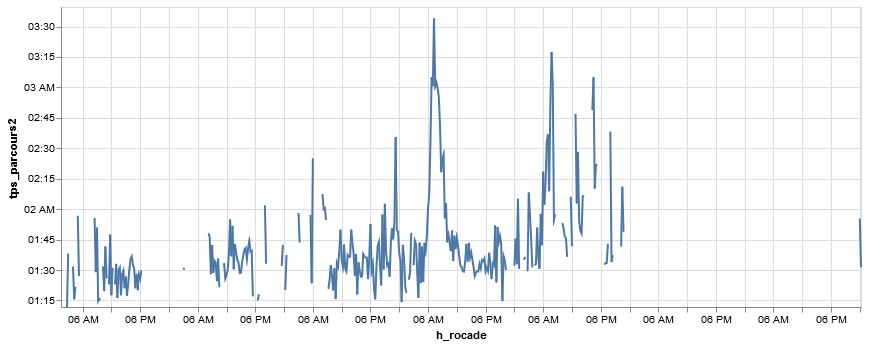

In [184]:
alt.Chart(pour_graph).mark_line().encode(
    x='h_rocade:T',
    y='tps_parcours2').properties(width=800)

In [ ]:
dico_od_final.loc[(dico_od_final['o_d']=='A10-A62') & (dico_od_final['date_cam_1']>pd.to_datetime('2019-01-28 21:00'))].sort_values('date_cam_1')

In [559]:
test=t.trajet(df_passages6.loc['2019-01-31 00:00:00':'2019-02-01 23:59:59'], '2019-01-31 08:15:00', 15, [8, 13],typeTrajet='Global',temps_max_autorise=18)

In [547]:
param_cluster=pd.read_json(r'Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\Traitements\python\param_cluster.json', orient='index')

In [563]:
visu=t.jointure_temps_reel_theorique(test.df_transit,dixco_tpsmax_corrige,t.liste_complete_trajet, 15)

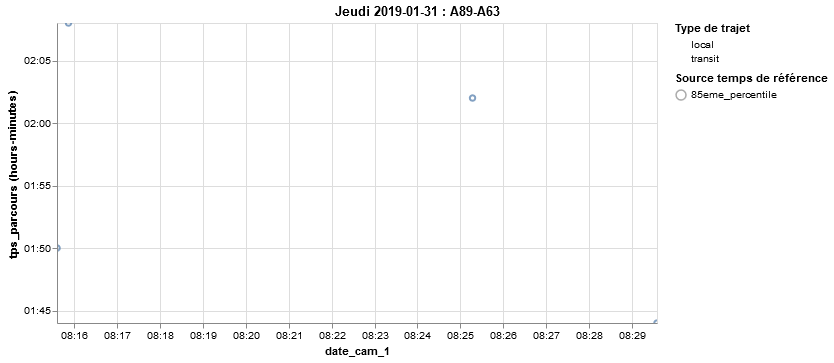

In [564]:
g.graph_transit_filtre(visu,'2019-01-31 00:00:00','2019-01-31 23:59:59','A89-A63')

# CORRIGER LES TEMPS DE PARCOURS LIMITES

In [162]:
#isoler les données : sur un jour pour une o_d
o_d='A10-A63'
date='2019-01-23'
test_predict=dico_df_transit['df_transit_marge0'].loc[(dico_df_transit['df_transit_marge0']['o_d']==o_d) &
             (dico_df_transit['df_transit_marge0'].set_index('date_cam_1').index.dayofyear==pd.to_datetime(date).dayofyear)].copy()

In [163]:
#ajouter des champsde ocnversion des dates en integer, limiter les valeusr sinon pb de mémoire avec sklearn
test_predict['date_int']=((test_predict.date_cam_1 - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'))/1000000
test_predict['temps_int']=(((pd.to_datetime('2018-01-01')+test_predict.tps_parcours) - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'))/1000000

In [1074]:
#créer les données d'entrée du modele
X=np.array([[a,b] for a,b in zip(test_predict.date_int.tolist(),test_predict.temps_int.tolist())])
y=np.array(test_predict.filtre_tps.tolist())

In [1075]:
#créer le modele
ga=1000
C=35
clf = svm.SVC(kernel='rbf', gamma=ga, C=C)

In [1076]:
#alimenter le modele
clf.fit(liste_nsample_nfeat, n_sample)

SVC(C=35, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1000, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [1077]:
#isoler les donner à tester
df_a_tester=test_predict.loc[(test_predict['filtre_tps']==0) & (test_predict['type']=='85eme_percentile')].copy()

In [1078]:
#liste à tester
liste_a_tester=np.array([[a,b] for a,b in zip(df_a_tester.date_int.tolist(),df_a_tester.temps_int.tolist())])
#dfde résultats de prédiction
df_type_predit=pd.DataFrame([[i, v] for i,v in zip(df_a_tester.index.tolist(),[clf.predict([x])[0] for x in liste_a_tester])], 
                            columns=['index_source','type_predit'])
#mise à jourde la df source
df_transit_avec_filtre.loc[df_transit_avec_filtre.index.isin(df_type_predit.index_source.tolist()),'type']='predit'
df_transit_avec_filtre.loc[df_transit_avec_filtre.index.isin(df_type_predit.loc[df_type_predit['type_predit']==1].index_source.tolist()),'filtre_tps']=1

In [1172]:
df_transit_avec_filtre.loc[df_transit_avec_filtre['type']=='predit']

,date_cam_1,immat,l,state,id,date_cam_2,cameras,origine,destination,o_d,tps_parcours,period,date,temps,type,tps_parcours_theoriq,filtre_tps


Wall time: 1.69 s


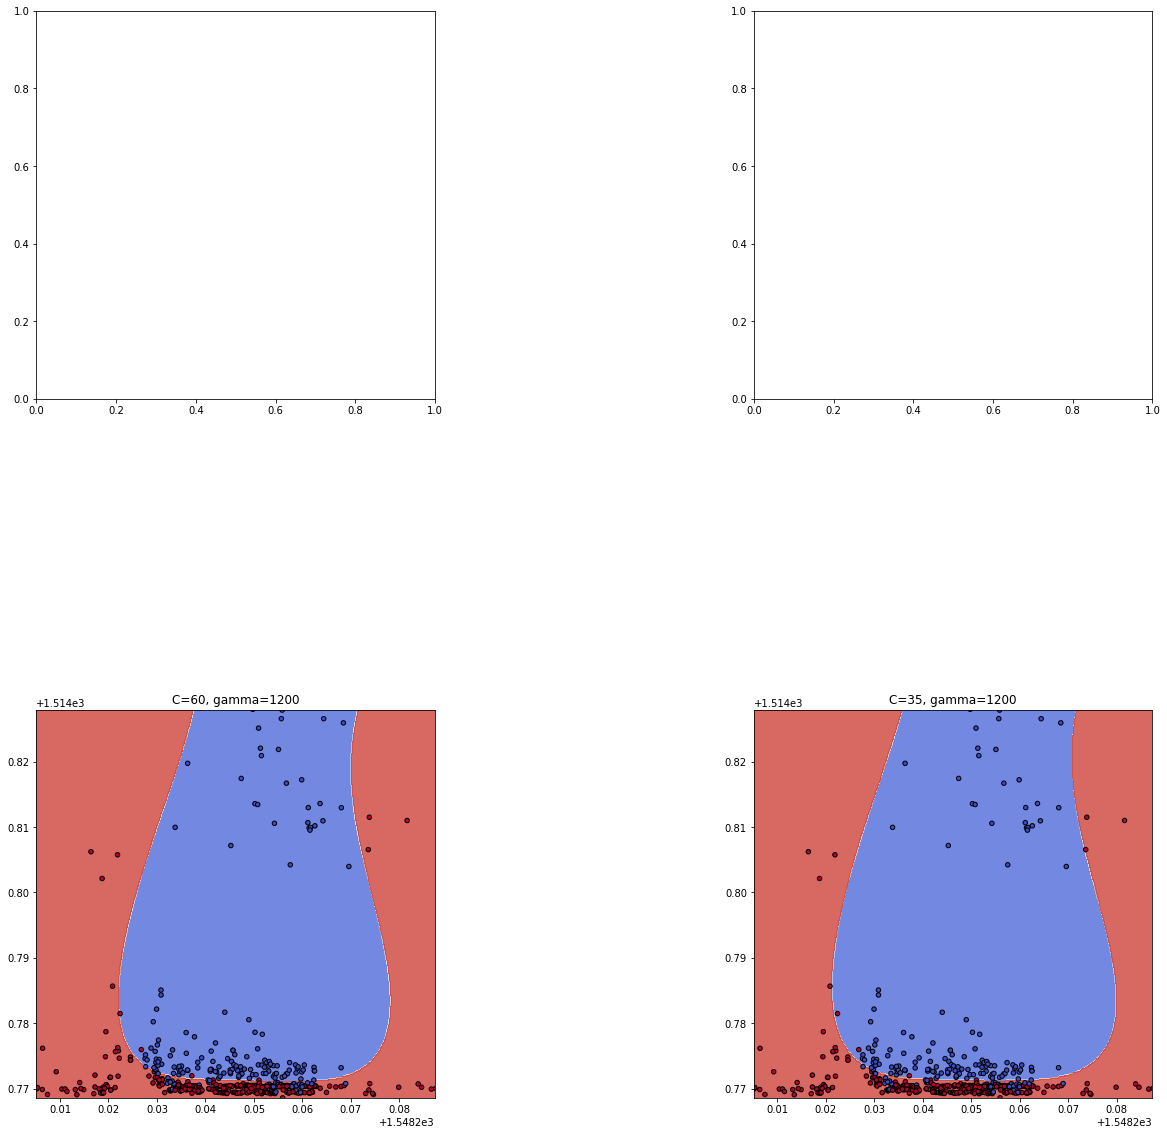

In [166]:
%%time
def make_meshgrid(x, y, h=.0002):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 0.000000001, x.max() + 0.000000001
    y_min, y_max = y.min() - 0.000000001, y.max() + 0.000000001
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

X=np.array([[a,b] for a,b in zip(test_predict.date_int.tolist(),test_predict.temps_int.tolist())])
y=np.array(test_predict.filtre_tps.tolist())
#C = 25# SVM regularization parameter
models = (svm.SVC(kernel='rbf', gamma=600, C=70),
         svm.SVC(kernel='rbf', gamma=600, C=35),
         svm.SVC(kernel='rbf', gamma=500, C=100),
         svm.SVC(kernel='rbf', gamma=500, C=200))
models = (clf.fit(X, y) for clf in models)


# Set-up 2x2 grid for plotting.
fig, sub = plt.figure(figsize=(20,20)).subplots(2,2)
plt.subplots_adjust(wspace=0.8, hspace=0.8)

# title for the plots
titles = ('C=60, gamma=1200',
          'C=35, gamma=1200',
          'C=100, gamma=500',
          'C=200, gamma=500')

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_title(title)

#plt.show()
plt.savefig(r'Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\Projet Rapport\illustrations\impact_prediction_A10-A63.png')

In [ ]:
liste_od_ok=['A660-A62','A62-A63','A63-A62','A62-A10','A660-N10', 'A660-A10','N10-A63','A62-N10']
for od in [x for x in df_transit_avec_filtre.o_d.unique().tolist() if x not in liste_od_ok ] : 
    for date in set([a[0].strftime('%Y-%m-%d') for a in t.creer_liste_date('2019-01-31',11)]):
        try : 
            df_transit_avec_filtre=t.predire_type_trajet(df_transit_avec_filtre,od, date,600,35)
        except ValueError : 
            continue

# VERIF AFFECTATION CLUSTER

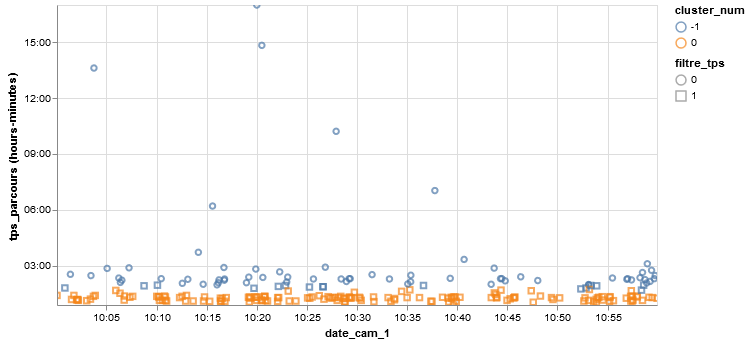

In [88]:
#test cluster
od='N10-A63'
date_debut='2019-01-23 10:00:00'
datefin='2019-01-23 11:00:00'
delai=1200
coeff=4
df_pl_ok=dico_df_transit['df_transit_marge15'].loc[(dico_df_transit['df_transit_marge15']['o_d']==od) &
                                   (dico_df_transit['df_transit_marge15']['date_cam_1'].between(pd.to_datetime(date_debut),pd.to_datetime(datefin)))]
donnees_src=df_pl_ok.loc[:,['date_cam_1','tps_parcours']].copy() #isoler les données necessaires
liste_valeur=donnees_src.tps_parcours.apply(lambda x : ((pd.to_datetime('2018-01-01')+x)-pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')).tolist()#convertir les temps en integer
liste_date=donnees_src.date_cam_1.apply(lambda x :(x - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')).tolist()
liste=[[liste_date[i],liste_valeur[i]] for i in range(len(liste_valeur))]
if len(liste_valeur)<5 : #si il n'y a pas bcp de pl on arrete ; pourraitfair l'objet d'un parametre
    raise ClusterError()
#faire tourner la clusterisation et recupérer le label (i.e l'identifiant cluster) et le nombre de cluster
clustering=DBSCAN(eps=delai, min_samples=len(liste_valeur)/coeff).fit(liste)

labels = clustering.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
# A AMELIORER EN CREANT UNE ERREUR PERSONALISEE SI ON OBTIENT  CLUSTER
if n_clusters_== 0 :
    print('vlaueError')
#mettre en forme au format pandas
results = pd.DataFrame(pd.DataFrame([donnees_src.index,labels]).T)
results.columns = ['index_base', 'cluster_num']
results = pd.merge(results,df_pl_ok, left_on='index_base', right_index=True )
graph_results=results[['date_cam_1','tps_parcours','filtre_tps','cluster_num']].copy()
graph_results.tps_parcours=pd.to_datetime('2018-01-01')+graph_results.tps_parcours
alt.Chart(graph_results).mark_point().encode(
                                x='date_cam_1',
                                y='hoursminutes(tps_parcours)',
                                tooltip='hoursminutes(tps_parcours)',
                                color='cluster_num:N',
                                shape='filtre_tps:N').interactive().properties(width=600)

In [77]:
t.param_cluster

,delai,nb_pt_min,temps_etudie,trajet
0,600,4,15,"[A10-A63, A89-A63, A62-A63, A10-A62, N10-A62, A89-A62, A10-A89, N10-A89, A10-A660, N10-A660, A89-A660, A62-A660]"
1,1200,4,60,"[A10-A63, N10-A63, A89-A63, A62-A63, A10-A62, N10-A62, A89-A62, A10-A89, N10-A89, A10-A660, N10-A660, A89-A660, A62-A660]"
2,800,3,15,"[A63-A10, A63-N10, A63-A89, A63-A62, A62-A10, A62-N10, A62-A89, A89-A10, A89-N10, A660-A10, A660-N10, A660-A89, A660-A62]"
3,1000,4,60,"[A63-A10, A63-N10, A63-A89, A63-A62, A62-A10, A62-N10, A62-A89, A89-A10, A89-N10, A660-A10, A660-N10, A660-A89, A660-A62]"
4,1000,4,15,N10-A63


In [99]:
{'toto'+str(i):i for i in [0,45,600]}

{'toto0': 0, 'toto45': 45, 'toto600': 600}

# TESTS

In [124]:
#selectionner les trajets realtif à A63, qui ne sont pas identifies comme transit
df_transit_A63_redresse=df_transit_extrapole.loc[(df_transit_extrapole['filtre_tps']==0)&(
    df_transit_extrapole.apply(lambda x : 'A63' in x['o_d'],axis=1))&(
    df_transit_extrapole.apply(lambda x : (18 in x['cameras'] or 19 in x['cameras']),axis=1))]

In [54]:
#trouver les passages correspondants
%time passage_transit_A63_redresse=t.trajet2passage(df_transit_A63_redresse,df_passages_immat_ok)

Wall time: 1min 27s


In [125]:
#retrouver le passage correspondants à 18 ou 19
df_transit_A63_redresse=df_transit_A63_redresse.merge(passage_transit_A63_redresse,on='immat')
df_transit_A63_redresse=df_transit_A63_redresse.loc[df_transit_A63_redresse['created'].between(df_transit_A63_redresse['date_cam_1'],df_transit_A63_redresse['date_cam_2'])]
df_transit_A63_redresse=df_transit_A63_redresse.loc[(df_transit_A63_redresse['camera_id'].isin([18,19])) & (df_transit_A63_redresse.apply(lambda x: x['camera_id'] in x['cameras'],axis=1))]
df_transit_A63_redresse=df_transit_A63_redresse.rename(columns={'l_x':'l','state_x':'state','created':'date_cestas'}).drop(['l_y','state_y','fiability','camera_id'],axis=1)

,date_cam_1,index,immat,l,state,id,plaque_ouverte,chiffree,plaque_valide,date_cam_2,cameras,origine,destination,o_d,tps_parcours,period,date,temps,type,tps_parcours_theoriq,temps_filtre,filtre_tps,date_cestas
1,2019-01-23 00:22:09,5839110,e8253b48cafa556d2bc4d077d97fa9dee507c3ee,1.0,ES,1044007,0893JTC,e8253b48cafa556d2bc4d077d97fa9dee507c3ee,True,2019-01-23 12:47:44,"(15, 19, 4, 5)",A63,N10,A63-N10,12:25:35,2019-01-23 00:00,2019-01-23 00:00:00,01:11:21,Cluster,01:03:47.194000,12:11:21,0,2019-01-23 00:52:53
14,2019-02-05 17:41:22,2811832,e8253b48cafa556d2bc4d077d97fa9dee507c3ee,1.0,ES,1044017,0893JTC,e8253b48cafa556d2bc4d077d97fa9dee507c3ee,True,2019-02-06 06:32:46,"(6, 3, 18, 13)",N10,A63,N10-A63,12:51:24,2019-02-05 17:30,2019-02-05 17:30:00,01:23:03,Cluster,01:04:01.001000,01:23:03,0,2019-02-05 18:21:17
17,2019-01-23 07:00:53,5839794,cea88baff57f696aec98f4d6144b6e74774087b6,1.0,ES,930000,0157KKB,cea88baff57f696aec98f4d6144b6e74774087b6,True,2019-01-23 19:36:45,"(15, 19, 4, 5)",A63,N10,A63-N10,12:35:52,2019-01-23 07:00,2019-01-23 07:00:00,01:19:05,Cluster,01:03:47.194000,01:19:05,0,2019-01-23 19:05:20
21,2019-01-23 07:02:00,5896701,98bed73843d18e602e9fd0ef39ce72ffc0835874,1.0,ES,687484,8006HJB,98bed73843d18e602e9fd0ef39ce72ffc0835874,True,2019-01-23 17:25:57,"(15, 19, 4, 5)",A63,N10,A63-N10,10:23:57,2019-01-23 07:00,2019-01-23 07:00:00,01:19:05,Cluster,01:03:47.194000,01:19:05,0,2019-01-23 16:42:16
25,2019-01-23 07:02:33,5839798,cdd6113d27b891563b7e3ec7fb1e6ae70c3b28cd,1.0,ES,926752,1806JLR,cdd6113d27b891563b7e3ec7fb1e6ae70c3b28cd,True,2019-01-23 09:00:15,"(15, 19, 4, 5)",A63,N10,A63-N10,01:57:42,2019-01-23 07:00,2019-01-23 07:00:00,01:19:05,Cluster,01:03:47.194000,01:19:05,0,2019-01-23 08:27:50


In [126]:
#affecter tps de parcours vers ou depuis Cestas
def tps_parcours_cestas(od,date_cam_1, date_cam_2, date_cestas):
    """
    calculer le temps de paroucrs depuis ou vers Cestas pour les o_d concernees par A63
    en entree : 
       od : string : origine_destination du trajet
       date_cam_1 : pd.timestamp : date de passage du debut du trajet
       date_cam_2 : pd.timestamp : date de passage de fin du trajet 
       date_cestas : pd.timestamp : date de passage à la camera de cestas
    en sortie : 
        tps_parcours_cestas : pd.timedelta : tps de parcours entre le debut et cestas ou entre cestas et la fin du trajet
    """
    if od.split('-')[0]=='A63':
        return date_cam_2-date_cestas
    else : 
        return date_cestas-date_cam_1
    
df_transit_A63_redresse['tps_parcours_cestas']=df_transit_A63_redresse.apply(
    lambda x : tps_parcours_cestas(x['o_d'], x['date_cam_1'], x['date_cam_2'], x['date_cestas']),axis=1)

In [138]:
#creer avec les temps de parcours theorique et reel de Cestas

#nouvel attribut pour traduire l'o_d cestas et les cameras cestas
df_transit_A63_redresse['o_d_cestas']=df_transit_A63_redresse.apply(
    lambda x : 'A660-'+x['o_d'].split('-')[1] if x['o_d'].split('-')[0]=='A63' else x['o_d'].split('-')[0]+'-A660',axis=1)
df_transit_A63_redresse['cameras_cestas']=df_transit_A63_redresse.apply(
    lambda x : x['cameras'][1:] if x['o_d'].split('-')[0]=='A63' else x['cameras'][:-1],axis=1)

#jointure avec temps theorique
df_transit_A63_redresse_tpq_theoriq=df_transit_A63_redresse.merge(t.liste_complete_trajet[['cameras','tps_parcours_theoriq']]
    ,left_on=['cameras_cestas'],right_on=['cameras']).drop('cameras_y',axis=1).rename(
    columns={'tps_parcours_theoriq_y':'tps_parcours_theoriq_cestas'})
#jointure avec temps reel
df_transit_A63_redresse_tstps=df_transit_A63_redresse_tpq_theoriq.merge(dixco_tpsmax_corrige, left_on=['o_d_cestas','period'],right_on=['o_d','period'],
    how='left').rename(columns={'cameras_x':'cameras','o_d_x':'o_d','date_x':'date','type_x':'type',
                                        'temps_x':'temps','tps_parcours_theoriq_x':'tps_parcours_theoriq',
                                       'temps_y':'temps_cestas','type_y':'type_cestas'}).drop(
    ['date_y','o_d_y'],axis=1)

In [138]:
#Maj de l'attribut temps_filtre_cestas
def temps_pour_filtre(date_passage,type_tps_lapi, tps_lapi, tps_theoriq):
    """pour ajouter un attribut du temps de parcours qui sert à filtrer les trajets de transit"""
    marge = 660 if date_passage.hour in [19,20,21,22,23,0,1,2,3,4,5,6] else 0  #si le gars passe la nuit, on lui ajoute 11 heure de marge
    if type_tps_lapi in ['Cluster','moyenne Cluster','predit']:
        return tps_lapi+pd.Timedelta(str(marge)+'min')
    else : 
        return tps_theoriq+pd.Timedelta(str(marge)+'min')   
df_transit_A63_redresse_tstps['temps_filtre_cestas']=df_transit_A63_redresse_tstps.apply(lambda x : temps_pour_filtre(x['date_cam_1'],
   x['type_cestas'], x['temps_cestas'], x['tps_parcours_theoriq_cestas']), axis=1)

In [158]:
#mise à jour attribut drapeau de transit
df_transit_A63_final=t.identifier_transit(df_transit_A63_redresse_tstps, 45,'temps_filtre_cestas','tps_parcours_cestas')

In [172]:
#Mise à jour structure table et ajout attribut drapeau de correction
df_transit_A63_attr_ok=df_transit_A63_final.drop([attr_cestas for attr_cestas in df_transit_A63_final.columns.tolist() if attr_cestas[-7:]=='_cestas'],axis=1)
df_transit_A63_attr_ok.loc[df_transit_A63_attr_ok['filtre_tps']==1,'correction_o_d']=True
df_transit_A63_attr_ok.loc[df_transit_A63_attr_ok['filtre_tps']==0,'correction_o_d']=False
df_transit_A63_attr_ok['correction_o_d_type']=df_transit_A63_attr_ok.apply(lambda x : 'temps_cestas' if x['correction_o_d'] else 'autre',axis=1)

In [ ]:
#insertion dans le df des trajets de transit avec u attribut a part (come pour les trajets incomplets)

In [173]:
df_transit_A63_attr_ok.head(10)

,date_cam_1,index,immat,l,state,id,plaque_ouverte,chiffree,plaque_valide,date_cam_2,cameras,origine,destination,o_d,tps_parcours,period,date,temps,type,tps_parcours_theoriq,temps_filtre,filtre_tps,correction_o_d,correction_o_d_type
0,2019-01-23 00:22:09,5839110,e8253b48cafa556d2bc4d077d97fa9dee507c3ee,1.0,ES,1044007,0893JTC,e8253b48cafa556d2bc4d077d97fa9dee507c3ee,True,2019-01-23 12:47:44,"(15, 19, 4, 5)",A63,N10,A63-N10,12:25:35,2019-01-23 00:00,2019-01-23 00:00:00,01:11:21,Cluster,01:03:47.194000,12:11:21,1,True,temps_cestas
1,2019-01-23 07:00:53,5839794,cea88baff57f696aec98f4d6144b6e74774087b6,1.0,ES,930000,0157KKB,cea88baff57f696aec98f4d6144b6e74774087b6,True,2019-01-23 19:36:45,"(15, 19, 4, 5)",A63,N10,A63-N10,12:35:52,2019-01-23 07:00,2019-01-23 07:00:00,01:19:05,Cluster,01:03:47.194000,01:19:05,1,True,temps_cestas
2,2019-01-23 07:02:00,5896701,98bed73843d18e602e9fd0ef39ce72ffc0835874,1.0,ES,687484,8006HJB,98bed73843d18e602e9fd0ef39ce72ffc0835874,True,2019-01-23 17:25:57,"(15, 19, 4, 5)",A63,N10,A63-N10,10:23:57,2019-01-23 07:00,2019-01-23 07:00:00,01:19:05,Cluster,01:03:47.194000,01:19:05,1,True,temps_cestas
3,2019-01-23 07:02:33,5839798,cdd6113d27b891563b7e3ec7fb1e6ae70c3b28cd,1.0,ES,926752,1806JLR,cdd6113d27b891563b7e3ec7fb1e6ae70c3b28cd,True,2019-01-23 09:00:15,"(15, 19, 4, 5)",A63,N10,A63-N10,01:57:42,2019-01-23 07:00,2019-01-23 07:00:00,01:19:05,Cluster,01:03:47.194000,01:19:05,1,True,temps_cestas
4,2019-01-23 07:02:45,5896703,920e4a31e78856eb31ac8fcbc0fe6d9d66be3926,1.0,PT,657000,61QJ85,920e4a31e78856eb31ac8fcbc0fe6d9d66be3926,True,2019-01-23 08:58:24,"(15, 19, 4, 5)",A63,N10,A63-N10,01:55:39,2019-01-23 07:00,2019-01-23 07:00:00,01:19:05,Cluster,01:03:47.194000,01:19:05,0,False,autre
5,2019-01-23 07:04:47,5839803,e3ece8b431dd22dcc46cf01a1217721afff8b354,1.0,DE,1024202,WNLS3235,e3ece8b431dd22dcc46cf01a1217721afff8b354,True,2019-01-23 09:07:52,"(15, 19, 4, 5)",A63,N10,A63-N10,02:03:05,2019-01-23 07:00,2019-01-23 07:00:00,01:19:05,Cluster,01:03:47.194000,01:19:05,0,False,autre
6,2019-01-23 07:05:11,5839805,131a1b876bbcd1e24d53bc25b4a1edd8bdfc9336,1.0,ES,85391,8091KLP,131a1b876bbcd1e24d53bc25b4a1edd8bdfc9336,True,2019-01-23 08:40:23,"(15, 19, 4, 5)",A63,N10,A63-N10,01:35:12,2019-01-23 07:00,2019-01-23 07:00:00,01:19:05,Cluster,01:03:47.194000,01:19:05,1,True,temps_cestas
7,2019-01-23 07:05:53,5839807,dd928accb0a169deb75a90d5ad998fa6055d3245,1.0,FR,996569,FA528KZ,dd928accb0a169deb75a90d5ad998fa6055d3245,True,2019-01-23 15:19:08,"(15, 19, 4, 5)",A63,N10,A63-N10,08:13:15,2019-01-23 07:00,2019-01-23 07:00:00,01:19:05,Cluster,01:03:47.194000,01:19:05,0,False,autre
8,2019-01-23 07:08:02,5839813,7fa1abefff9c6c8f3c68048cabcb17b5d254b9f5,1.0,PL,571365,WGM40887,7fa1abefff9c6c8f3c68048cabcb17b5d254b9f5,True,2019-01-23 08:51:48,"(15, 19, 4, 5)",A63,N10,A63-N10,01:43:46,2019-01-23 07:00,2019-01-23 07:00:00,01:19:05,Cluster,01:03:47.194000,01:19:05,1,True,temps_cestas
9,2019-01-23 07:08:15,5839814,7fcc6dd8812f703a7b374dee07b023b20b21e95a,1.0,PT,572242,53VI71,7fcc6dd8812f703a7b374dee07b023b20b21e95a,True,2019-01-23 09:01:21,"(15, 19, 4, 5)",A63,N10,A63-N10,01:53:06,2019-01-23 07:00,2019-01-23 07:00:00,01:19:05,Cluster,01:03:47.194000,01:19:05,1,True,temps_cestas


In [162]:
[attr_cestas for attr_cestas in df_transit_A63_final.columns.tolist() if attr_cestas[-7:]=='_cestas']

['date_cestas',
 'tps_parcours_cestas',
 'o_d_cestas',
 'cameras_cestas',
 'tps_parcours_theoriq_cestas',
 'temps_cestas',
 'type_cestas',
 'temps_filtre_cestas']